In [3]:
!pip install pyod

In [5]:
import numpy as np
import pyod as po
from pyod.utils.utility import standardizer
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report
from pyod.utils.utility import standardizer
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from pyod.models.ocsvm import OCSVM
from pyod.models.deep_svdd import DeepSVDD
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from matplotlib.pyplot import scatter

In [14]:
#ex1

X_test, X_train, y_test, y_train = po.utils.data.generate_data(
                                      n_train = 300,
                                      n_test = 200,
                                      n_features = 3,
                                      contamination = 0.15)

OCSVM_linear = OCSVM(kernel = "linear",contamination = 0.15)
OCSVM_linear.fit(X_train)

y_test_pred_linear = OCSVM_linear.predict(X_test)
y_test_scores_linear = OCSVM_linear.decision_function(X_test)

bal_acc_linear = balanced_accuracy_score(y_test, y_test_pred_linear)
roc_auc_linear = roc_auc_score(y_test, y_test_scores_linear)

print ("Linear Kernel:")
print (f"Balanced accuracy: {bal_acc_linear}")
print (f"ROC AUC: {roc_auc_linear}")

OCSVM_rbf = OCSVM(kernel = "rbf",contamination = 0.15)
OCSVM_rbf.fit(X_train)

y_test_pred_rbf = OCSVM_rbf.predict(X_test)
y_test_scores_rbf = OCSVM_rbf.decision_function(X_test)

bal_acc_rbf = balanced_accuracy_score(y_test, y_test_pred_rbf)
roc_auc_rbf = roc_auc_score(y_test, y_test_scores_rbf)

print ()
print ("RBF Kernel:")
print (f"Balanced accuracy: {bal_acc_rbf}")
print (f"ROC AUC: {roc_auc_rbf}")

y_train_pred_linear = OCSVM_linear.predict(X_train)
y_train_pred_rbf = OCSVM_rbf.predict(X_train)

Linear Kernel:
Balanced accuracy: 0.9718954248366014
ROC AUC: 0.9961655773420479

RBF Kernel:
Balanced accuracy: 0.95359477124183
ROC AUC: 0.9731590413943355


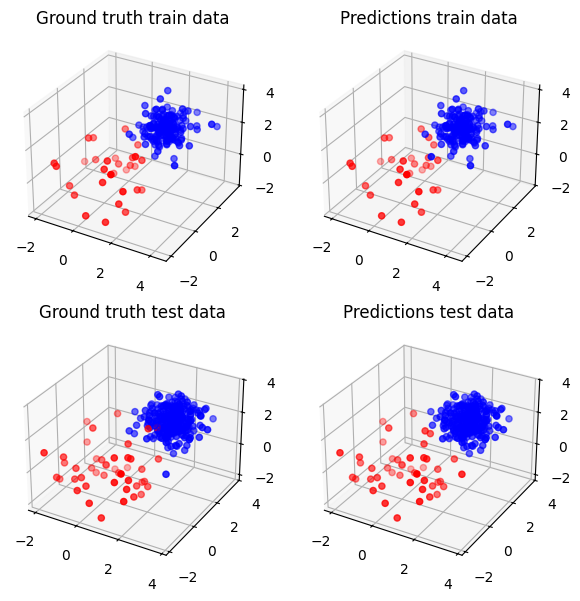

In [17]:
fig, plots = plt.subplots(2, 2, figsize=(7, 7), subplot_kw={"projection":"3d"})

plots[0, 0].scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=['b' if x == 0 else 'r' for x in y_train])
plots[0, 0].set_title("Ground truth train data")

plots[1, 0].scatter(X_test[: , 0], X_test[:, 1], X_test[:, 2], c=['b' if x == 0 else 'r' for x in y_test])
plots[1, 0].set_title("Ground truth test data")

plots[0, 1].scatter(X_train[:, 0], X_train[:, 1], X_train[: ,2], c=['b' if x == 0 else 'r' for x in y_train_pred_linear])
plots[0, 1].set_title("Predictions train data")

plots[1, 1].scatter(X_test[: , 0], X_test[:, 1], X_test[:, 2], c=['b' if x == 0 else 'r' for x in y_test_pred_linear])
plots[1, 1].set_title("Predictions test data")

plt.show()

In [20]:
#ex2

data = loadmat('cardio 1.mat')
X = data['X']
y = data['y'].ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.4,
    random_state=42,
    stratify=y
)


# 1 - 2 * y_pyod
#print(y_train)
y_train = 1 - 2 * y_train
y_test  = 1 - 2 * y_test

n_outliers = np.sum(y_train == -1)
n_samples = len(y_train)
contamination_rate = n_outliers / n_samples

nu_values = [0.05, 0.1, contamination_rate, 0.2, 0.3]


nu_values = sorted(list(set([n for n in nu_values if 0 < n <= 1])))


param_grid = {
    'svm__kernel': ['rbf', 'sigmoid', 'poly', 'linear'],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'svm__nu': nu_values
}


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', OneClassSVM())
])


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nBest Parameters Found:")
print(grid_search.best_params_)
print(f"Best CV Balanced Accuracy: {grid_search.best_score_:.4f}")


best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)


test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
print(f"Test Set Balanced Accuracy: {test_bal_acc:.4f}")

print("\n--- Final Evaluation on Test Set (60% split) ---")

print(classification_report(y_test, y_test_pred, target_names=['Outlier (-1)', 'Inlier (1)']))

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters Found:
{'svm__gamma': 0.001, 'svm__kernel': 'rbf', 'svm__nu': 0.3}
Best CV Balanced Accuracy: 0.8695
Test Set Balanced Accuracy: 0.8957

--- Final Evaluation on Test Set (60% split) ---
              precision    recall  f1-score   support

Outlier (-1)       0.37      0.97      0.53       106
  Inlier (1)       1.00      0.82      0.90       993

    accuracy                           0.83      1099
   macro avg       0.68      0.90      0.72      1099
weighted avg       0.94      0.83      0.86      1099



In [22]:
#ex3

def evaluate_model(model, X_test, y_test, model_name):

  y_test_scores = model.decision_function(X_test)
  y_test_pred = model.predict(X_test)


  roc = roc_auc_score(y_test, y_test_scores)
  ba = balanced_accuracy_score(y_test, y_test_pred)

  return roc, ba

data = loadmat('shuttle 1.mat')
X = data['X']
y = data['y'].ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.5,
    random_state=42,
    stratify=y
)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape[1]

9

In [27]:
contamination = np.sum(y_train == 1) / len(y_train)


ocsvm_model = OCSVM(kernel='rbf', contamination=contamination)
ocsvm_model.fit(X_train)
roc, ba = evaluate_model(ocsvm_model, X_test, y_test, 'OCSVM')
print(f"ROC: {roc} , BA: {ba}")

ROC: 0.9913999442541555 , BA: 0.974677190285512


In [28]:
deep_svdd_default = DeepSVDD(
    n_features = 9,
    contamination = contamination,
    epochs = 20,
    verbose = 0
)
deep_svdd_default.fit(X_train)
roc, ba = evaluate_model(deep_svdd_default, X_test, y_test, 'DeepSVDD Default')
print(f"ROC: {roc} , BA: {ba}")

Epoch 1/20, Loss: 503.6779983267188
Epoch 2/20, Loss: 503.20017086341977
Epoch 3/20, Loss: 503.5288922339678
Epoch 4/20, Loss: 503.2536956593394
Epoch 5/20, Loss: 503.2177920937538
Epoch 6/20, Loss: 503.56008476018906
Epoch 7/20, Loss: 503.4289232492447
Epoch 8/20, Loss: 504.0665315538645
Epoch 9/20, Loss: 503.36573400348425
Epoch 10/20, Loss: 503.4865417480469
Epoch 11/20, Loss: 503.66933596134186
Epoch 12/20, Loss: 503.2699600458145
Epoch 13/20, Loss: 503.2862970158458
Epoch 14/20, Loss: 503.4110228717327
Epoch 15/20, Loss: 504.4202395826578
Epoch 16/20, Loss: 503.22549737244844
Epoch 17/20, Loss: 504.20661866664886
Epoch 18/20, Loss: 503.6593205779791
Epoch 19/20, Loss: 503.2097622603178
Epoch 20/20, Loss: 503.3693844154477
ROC: 0.984870619771266 , BA: 0.8989505005283263


In [26]:
architectures = {
    "Shallow": [32, 16],
    "Deep": [64, 32, 16, 8],
    "Wide": [128, 64],
}

results = {}

for name, hidden_neurons in architectures.items():
  model = DeepSVDD(
      n_features = 9,
      hidden_neurons = hidden_neurons,
      contamination = contamination,
      epochs = 20,
      verbose = 0
  )

  model.fit(X_train)
  roc, ba = evaluate_model(model, X_test, y_test, name)
  results[name] = {"ROC" : roc, "BA" : ba}

for name, metrics in results.items():
  print(f"{name} - ROC: {metrics['ROC']:.4f}, BA: {metrics['BA']:.4f}")

Epoch 1/20, Loss: 394.4201682060957
Epoch 2/20, Loss: 393.9807872697711
Epoch 3/20, Loss: 393.96958277374506
Epoch 4/20, Loss: 393.89980418235064
Epoch 5/20, Loss: 394.14469028264284
Epoch 6/20, Loss: 394.1296164691448
Epoch 7/20, Loss: 394.27287070453167
Epoch 8/20, Loss: 393.9220011383295
Epoch 9/20, Loss: 393.94249218702316
Epoch 10/20, Loss: 393.9042591303587
Epoch 11/20, Loss: 394.2124973088503
Epoch 12/20, Loss: 394.3889740332961
Epoch 13/20, Loss: 394.36041194945574
Epoch 14/20, Loss: 394.11049274355173
Epoch 15/20, Loss: 393.91048304364085
Epoch 16/20, Loss: 393.90117399021983
Epoch 17/20, Loss: 393.8787703104317
Epoch 18/20, Loss: 394.5627496764064
Epoch 19/20, Loss: 394.4302780404687
Epoch 20/20, Loss: 393.92594090104103
Epoch 1/20, Loss: 1.687731093239563
Epoch 2/20, Loss: 1.5460491208650637
Epoch 3/20, Loss: 1.4559340255218558
Epoch 4/20, Loss: 1.5883319287531776
Epoch 5/20, Loss: 1.5258039864093007
Epoch 6/20, Loss: 1.9675331446924247
Epoch 7/20, Loss: 1.4402831691259053
E